# 調和励振系の数値シミュレーション

吉田勝俊（宇都宮大学）

## 参考情報

- [Pythonで運動方程式を解く(odeint) - Qiita](https://qiita.com/binaryneutronstar/items/ad5efa27fd626826846f)
- [[Python] Numpyの参照、抽出、結合 - Qiita](https://qiita.com/supersaiakujin/items/d63c73bb7b5aac43898a)
- [[Python/matplotlib] FuncAnimationを理解して使う - Qiita](https://qiita.com/osanshouo/items/3c66781f41884694838b)
- [2つの信号間の遅延を推定する - Qiita](https://qiita.com/inoory/items/3ea2d447f6f1e8c40ffa)

In [1]:
import numpy as np                              #数値計算ライブラリ
from math import sin, cos                       #低機能だが高速な数学関数・定数
from numpy.linalg import norm                   #ベクトルのノルム
from scipy.integrate import odeint              #常微分方程式ライブラリ
import matplotlib.pyplot as plt                 #描画ライブラリ
from matplotlib import rc                       #グラフ調整ライブラリ
from matplotlib.animation import FuncAnimation  #アニメーションライブラリ
#Colab用の設定（グラフィックのインライン表示）
%matplotlib inline

## 調和励振系の運動方程式

In [2]:
def org_funcs():
    '''
    調和励振系（原形 original）の外力と運動方程式
    '''
    def force(t, param):
        '''
        外力 f(t)
        '''
        m, c, k, P, Om = param
        ft = P*sin(Om*t)
        
        return ft 

    def eom(x, t, param):
        '''
        運動方程式
        '''
        m, c, k, P, Om = param
        return np.array([
            x[1],
            -(c/m)*x[1] - (k/m)*x[0] + force(t,param)
        ])

    return (force, eom)

def can_funcs():
    '''
    調和励振系（正規形 cannonical）の外力と運動方程式
    '''
    def force(tau, param):
        '''
        無次元化した外力 h(tau)
        '''
        zeta, A, om = param
        ht = A*sin(om*tau)
        
        return ht 

    def eom(y, tau, param):
        '''
        調和励振系の運動方程式（正規形 cannonical）
        '''
        zeta, A, om = param
        return np.array([
            y[1],
            -2*zeta*y[1] - y[0] + force(tau,param)
        ])

    return (force, eom)

In [3]:
def Solve(funcs, param, x0, time, new_om=None):
    '''
    調和励振系の数値解を求める関数\n",
    '''
    force, eom = funcs()     #外力と運動方程式の取得
    new_param = param.copy() #元のparamを書き換えぬよう複製
    
    if new_om is not None:
        new_param[-1] = new_om   #最終成分＝外力角振動数
        
    ###運動方程式を数値的に解く
    motion = odeint(
        eom,                #運動方程式を表すユーザ関数
        x0,                 #初期条件
        time,               #時間軸を表す数列
        args=(new_param,)   #運動方程式の係数
    )
    
    ###外力の数列を作る
    forces = np.array([
        force(t, new_param) for t in time
    ])

    return (forces, motion)

## 演習 5.2 (1): 外力と変位の振動波形（原形）

In [4]:
def draw_waves(axs, ts, forces, xs, 
               inlab=r'$f(t)$', outlab=r'$x(t)$',
               ymax1=2, ymax2=2,
               title=None ):
    '''
    外力と変位の振動波形を描画する関数
    '''
    ax1, ax2 = axs #第１軸, 第２軸
    
    ax1.plot(ts, forces,   label=inlab,  color='gray') #入力
    ax2.plot(ts, xs[:, 0], label=outlab, color='red')  #出力

    ax1.set_ylim(-ymax1, ymax1) #縦軸の範囲
    ax2.set_ylim(-ymax2, ymax2)

    ax1.set_ylabel('Input Amplitude',  fontsize=15, color='gray')
    ax2.set_ylabel('Output Amplitude', fontsize=15, color='red')

    ax1.set_xlabel('Time', fontsize=16)

    ax1.legend(fontsize=14, loc='upper left') #凡例の表示
    ax2.legend(fontsize=14, loc='upper right') #凡例の表示

    ax1.grid()   #グリッド線の表示
    
    if title is not None:
        ax1.set_title(title, fontsize=14)
        
        
def output_waves(ts, forces, xs, 
                 inlab=r'$f(t)$', outlab=r'$x(t)$', 
                 ymax1=2, ymax2=2):
    '''
    振動波形の描画を出力する関数
    '''
    fig, ax = plt.subplots(1,1, figsize=(7,3))
    axs = [ax, ax.twinx()]  #第１軸, 第２軸
    
    draw_waves(axs, ts, forces, xs, inlab, outlab, ymax1, ymax2)
    fig.tight_layout()

### 計算結果

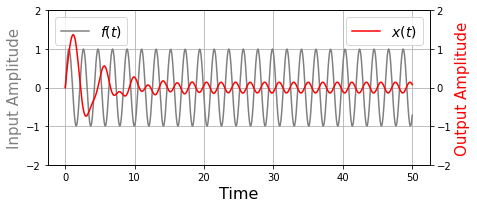

In [5]:
org_param = [
    1,    # m: 質量 
    0.5,  # c: 減衰係数
    2,    # k: ばね定数
    1,    # P: 外力振幅
    3,    # Om: 外力角振動数
]

X0 = [
    0,  #初期変位 
    2,  #初速度
]

ts = np.linspace(0,50,500) #時間軸を表す数列（0〜50秒を500等分）
forces, xs = Solve(funcs=org_funcs, param=org_param, x0=X0, time=ts)
output_waves(ts, forces, xs)

### おまけ: 外力と変位の振動波形（正規形）

初期条件も，速度については変換が必要です．

- $x(t)=y(\omega_n t)$ が成立するので，$t=0$ を代入すると，$x(0)=y(0)$ になります．
- $x(t)=\omega_n y(\omega_n t)$ が成立するので，$t=0$ を代入すると，$x(0)=\omega_n y(0)$ または $y(0)=x(0)/\omega_n$ になります．

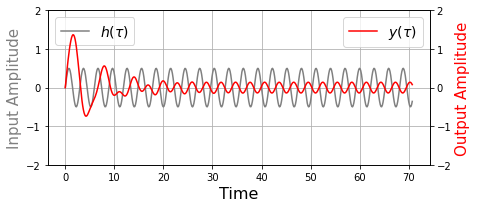

In [6]:
def convert_can_from_org(org_param, x0, ts):
    # 原形のパラメータ
    m, c, k, P, Om = org_param
    
    # 対応する正規形のパラメータ
    zeta = c/(2*np.sqrt(m*k))
    om_n = np.sqrt(k/m)
    A = P/k
    om = Om/om_n
    
    can_param = [
        zeta,  # zeta: 減衰比
        A,     # A: 無次元外力振幅
        om,    # om: 無次元外力角振動数
    ]
    
    y0 = x0.copy()     #x0 を変えないため，x0のコピーを作り代入
    y0[1] = x0[1]/om_n #初速度は変換が必要
    
    # 対応する無次元時間
    taus = om_n * ts

    return (can_param, y0, taus)

can_param, Y0, taus = convert_can_from_org(org_param, X0, ts)

forces, ys = Solve(
    funcs=can_funcs, 
    param=can_param, 
    x0=Y0, 
    time=taus, 
)

output_waves(taus, forces, ys, inlab=r'$h(\tau)$', outlab=r'$y(\tau)$')

## 演習 5.2 (2): 原形と正規形の比較

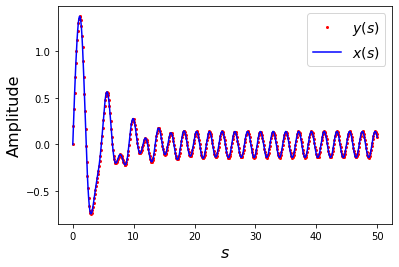

In [7]:
ss = ts #横軸データは流用
plt.plot(ss, ys[:, 0], 'or', label=r'$y(s)$', ms=2) #正規形の基準波形
plt.plot(ss, xs[:, 0], '-b', label=r'$x(s)$') #原形の振動波形
plt.xlabel(r'$s$', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.legend(fontsize=14)

- $x(t)$ と $y(\tau)$ を単なる１変数関数と見て，同じ横軸 $s$ にプロットすると重なるので，両者の振動波形は確かに相似です．
- 若干ずれて見えますが，これは描画ライブラリの誤差です．

## 演習 5.4 ( ボード線図の目測 )

In [8]:
def animate_sweep_om(funcs, param, x0, time, oms):
    '''
    入力周波数による振動波形をアニメーションする関数
    '''
    fig, ax = plt.subplots(1,1, figsize=(7,3))
    axs = [ax, ax.twinx()]  #第１軸, 第２軸

    plot1 = plot2 = None #描画を収める変数（最初は空）
    def each_frame(iom):
        '''
        パラパラマンガの1コマを描く関数
        '''
        #iom番目のomegaにおける数値解
        om = oms[iom]
        forces, xs = Solve(funcs, param, x0, time, om)
        
        #現在のコマを描画
        for ax in axs:
            ax.cla() # 描画をクリア
        title = r'$\Omega$ = %.2f'%(om)
        draw_waves(axs, time, forces, xs, title=title)
        fig.tight_layout()
        
    anim = FuncAnimation(
        fig, each_frame, 
        interval=200, frames=len(oms)
    )

    rc('animation', html='jshtml')
    return anim

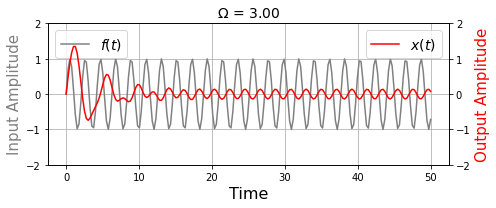

In [9]:
# 多少時間がかかります．

ts = np.linspace(0, 50, 200) #時間軸を表す数列（0〜100秒を200等分）
oms = np.linspace(0.3, 3, 100)
animate_sweep_om(org_funcs, org_param, X0, ts, oms)

- 出力 $x(t)$ の振幅は，入力角振動数 $\Omega$ とともに，いったん増加してから，減少する．
- 出力の振動数は，振動が落ち着いた以降は，入力と同じになる．
- 入力と出力の波形の，位置関係（山と谷）に着目すると，
 - $\Omega$ が小さいところでは，入力と出力の山（谷）は，だいたい同じ位置．（同相という）
 - $\Omega$ を増加させると，出力の位置が，だんだん遅れてくる．
 - $\Omega$ が大きいところでは，入力の山が，出力の谷になる．（逆相という）

## 演習 5.5 ( ゲイン線図の数値計算 )

In [10]:
def measure_gain_plot(funcs, param, x0, min_om, max_om, n_om, dTn=30, Tn=50):
    '''
    ゲイン線図をシミュレーション波形から測定する関数
    '''
    # 初期設定
    x0copy = x0.copy()  #初期値のコピー（元を書き換えない）
    oms    = np.linspace(min_om, max_om, n_om) #外力振動数の軸
    tn     = dTn*Tn     #時間軸の総ステップ数 = (1周期当り)*(計算する周期の個数)
    P      = param[-2]  #入力振幅＝パラメータの後ろから2番め
    
    # 測定結果を収める配列
    Rs  = np.zeros(n_om)  #変位の定常応答振幅
 
    # 入力波形の末尾4周期
    tail_len = 4*dTn           # 末尾の長さ
    tail_idx = tn - tail_len # 末尾が始まるインデックス

    for i, om in enumerate(oms):

        # 時間軸の長さを，入力の山の数で決める
        T = 2*np.pi/om                  #入力の周期
        time = np.linspace(0, T*Tn, tn) #Tn周期分の時間軸
        
        # 応答を求める
        forces, xs = Solve(funcs, param, x0copy, time, om)

        # 応答の末尾部分（≒定常応答）を抽出
        xs_     = xs[tail_idx:,:]
        
        # P-Pを測定する
        xPP  = max(xs_[:,0]) - min(xs_[:,0]) #後半のP-P（変位）

        # 振幅比をストア
        Rs[i]  = (xPP/2)/P    #(正弦波の振幅=(P-P)/2)/入力振幅

        x0copy = xs[-1,:]     #現在の終端値を，次の初期値にする
        
    return (oms, Rs)

### ゲイン線図の計算結果

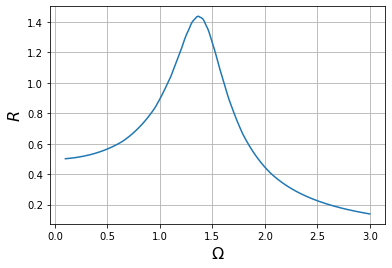

In [11]:
oms, Rs = measure_gain_plot(org_funcs, org_param, X0, 0.1, 3, 200)

plt.plot(oms, Rs)
plt.xlabel(r'$\Omega$', fontsize=16)
plt.ylabel(r'$R$', fontsize=16)
plt.grid()

## 演習 5.6 (位相線図の数値計算  )

### 準備（位相差を推定するユーザ関数）

- 相互相関関数を使った方法が，ネットでちらほらヒットするので，ちとやってみる．

t_delay =  -1.5393804002589988


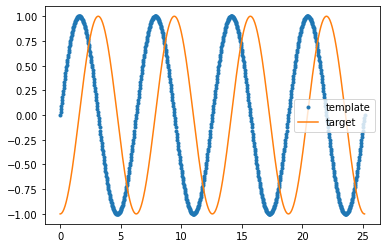

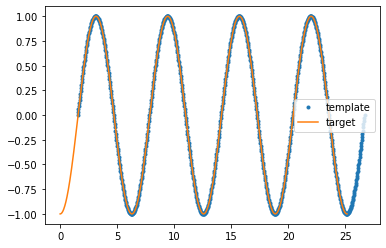

In [12]:
def estimate_delay(ts, target, template):
    '''
    2つの波形の違いが最小（＝相互相関関数が最大）
    となる遅れ時間を求める関数
    '''
    # 相互相関関数の計算
    # Numpy仕様: len(corrs) = len(target) + len(template) - 1
    corrs_full = np.correlate(target, template, 'full')
    
    # template由来の境界効果部分（先頭）を除く
    corrs = corrs_full[len(template)-1:]

    # 相互相関関数が最大値となるインデックス
    i_shift = corrs.argmax()

    if i_shift >= 0:
        t_delay = -ts[i_shift] #遅れが負（位相差に合わせる）
    else:
        t_delay = ts[-i_shift]
        
    return t_delay

def test_estimate_delay():
    '''
    テスト用の関数
    '''
    # サンプル波形
    sample_phi = -np.pi/2

    # 対象のテスト信号
    targ_ts  = np.linspace(0, 8*np.pi, 801)
    target   = np.sin(targ_ts + sample_phi)

    # テンプレート信号
    temp_ts  = np.linspace(0, 8*np.pi, 801)
    template = np.sin(temp_ts)

    plt.figure()
    plt.plot(temp_ts, template, '.', label='template')
    plt.plot(targ_ts, target,   '-', label='target')
    plt.legend()
    
    delay_ts = targ_ts
    t_delay = estimate_delay(delay_ts, target, template)
    
    print('t_delay = ',t_delay)

    plt.figure()
    plt.plot(temp_ts-t_delay, template, '.', label='template')
    plt.plot(targ_ts,         target,   '-', label='target')
    plt.legend()
    
test_estimate_delay()

### 本題（位相線図の数値計算）

In [13]:
def measure_phase_plot(funcs, param, x0, min_om, max_om, n_om, dTn=30, Tn=50):
    '''
    位相線図をシミュレーション波形から測定する関数
    '''
    # 初期設定
    x0copy  = x0.copy() #初期値のコピー（元を書き換えない）
    oms     = np.linspace(min_om, max_om, n_om) #外力振動数の軸
    tn      = dTn*Tn  #時間軸の総ステップ数 = (1周期当り)*(計算する周期の個数)

    # 入力波形の末尾4周期
    tail_len = 4*dTn          # 末尾の長さ
    tail_idx = tn - tail_len  # 末尾が始まるインデックス

    # 位相差の測定結果を収める配列
    phi_x  = np.zeros(n_om) #変位
        
    for i, om in enumerate(oms):
        
        # 時間軸の長さを，入力の山の数で決める
        T = 2*np.pi/om                  #入力の周期
        time = np.linspace(0, T*Tn, tn) #Tn周期分の時間軸
        
        # 応答を求める
        forces, xs = Solve(funcs, param, x0copy, time, om)

        # 応答の末尾部分（≒定常応答）を抽出
        forces_ = forces[tail_idx:]  #入力
        x_      = xs[tail_idx:,0]    #出力（変位）
        
        # 変位の位相差を推定する
        # forces_を基準波形に，x_がどれだけ遅れるか
        t_delay = estimate_delay(time, x_, forces_)
        phi      = om * t_delay #外力の位相＝om*時間
        phi_x[i] = phi
        
        x0copy = xs[-1,:] #現在の終端値を，次の初期値にする

    def reshape(phis):
        '''
        位相差を 0 〜 -pi の連続関数に整形する関数
        '''
        #0 〜 -pi の範囲に折りたたむ
        phis = np.fmod(phis, np.pi)
    
        #段差を無くす
        unit = np.pi
        prev_phi = phis[0]
        for i, phi in enumerate(phis):
            err = prev_phi-phi
            err_n = np.floor(err/unit)
            if err_n > 0:
                phis[i] = phi - err_n * unit
                
            prev_phi = phis[i]
        
        return phis

    phi_x  = reshape(phi_x)
        
    return (oms, phi_x)

### 位相線図の計算結果

In [14]:
oms, phi_x = measure_phase_plot(
    org_funcs, org_param, X0, 0.1, 3, n_om=200, dTn=200)

# n_om, dTn を増やすと，グラフは滑らかになりますが，時間が掛かります

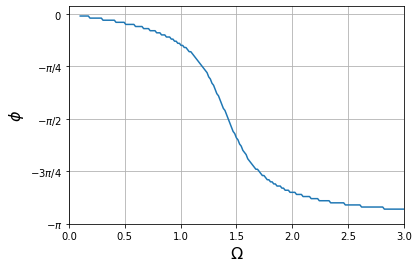

In [15]:
plt.plot(oms, phi_x)
plt.xlabel(r'$\Omega$', fontsize=16)
plt.ylabel(r'$\phi$', fontsize=16)
plt.yticks(
    np.linspace(0,-np.pi,5),
    [r'$0$',r'$-\pi/4$',r'$-\pi/2$',r'$-3\pi/4$',r'$-\pi$']
)
plt.xlim([0,3])
plt.grid()

- 入力振動数 $\Omega$ が低いと，位相差 $\phi$ は 0 に近くなります．
 - 出力波形の山と谷が，入力波形のそれと同期する．（同相）
- 入力振動数 $\Omega$ が高いと，位相差 $\phi$ は $-\pi$ に近くなります．
 - 出力波形の山と谷が，入力波形と互い違いになる．（逆相）

# 非線形振動の例

## 演習2.7

### ガタのある調和励振系

$m\ddot x + c\dot x + k\,F_{\mathrm{gata}}(x,\eta) =P\sin(\Omega t),\quad$ 
$F_{\mathrm{gata}}(x,\eta):=\begin{cases}
 x       & (x < 0)
 \\
 0       & (0 \leq x< \eta)
 \\
 x - \eta & (\eta \leq x)
 \\
\end{cases}$

を1階化すると，

$\begin{cases}
 \dot x_1 = x_2
 \\
 \dot x_2 =  \{-k\,x_1 - c\,x_2 - k\,F_{\mathrm{gata}}(x,\eta) + P\sin(\Omega t)\}/m 
\end{cases}$

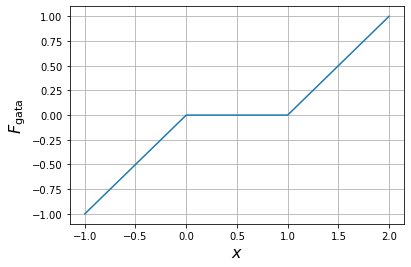

In [16]:
def Fgata(x, eta):
    '''
    ガタのあるバネを表す関数
    '''
    if x < 0:
        F = x
    elif 0 <= x < eta:
        F = 0
    else:
        F = x - eta

    return F

#お試しプロット
xs = np.linspace(-1,2,100)
Fgatas = np.array([
  Fgata(x, eta=1) for x in xs  
])

plt.plot(xs, Fgatas)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$F_{\mathrm{gata}}$', fontsize=16)
plt.grid()

In [17]:
def gata_funcs():
    '''
    ガタのある調和励振系の外力と運動方程式
    '''

    def force(t, param):
        '''
        外力 f(t)
        '''
        m, c, k, eta, P, Om = param
        ft = P*sin(Om*t)
        
        return ft

    def eom(x, t, param):
        '''
        運動方程式
        '''
        m, c, k, eta, P, Om = param

        return np.array([
            x[1],
            ( -k*x[0] -c*x[1] - k*Fgata(x[0], eta) + force(t,param) )/m
        ])

    return (force, eom)

### ガタがある場合の共振曲線

In [18]:
X0 = [
    0,  #初期変位 
    2,  #初速度
]

gata_param = [
    1,    # m:   質量 
    0.02, # c:   減衰係数
    1,    # k:   ばね定数
    0.4,  # eta: ガタの大きさ
    0.1,  # P:   外力振幅
    3,    # Om:  外力角振動数
]

#以下，少々時間がかかります．

#上昇掃引
oms_u, Rs_u = measure_gain_plot(
    gata_funcs, gata_param, X0, 
    min_om=1, max_om=1.6, n_om=200, Tn=150
)
#下降掃引
oms_d, Rs_d = measure_gain_plot(
    gata_funcs, gata_param, X0, 
    min_om=1.6, max_om=1, n_om=200, Tn=150
)

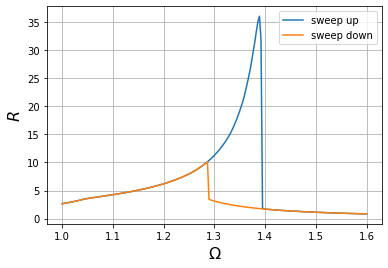

In [19]:
plt.plot(oms_u, Rs_u, label='sweep up')
plt.plot(oms_d, Rs_d, label='sweep down')
plt.xlabel(r'$\Omega$', fontsize=16)
plt.ylabel(r'$R$', fontsize=16)
plt.legend()
plt.grid()

### ガタの影響

#### 跳躍・履歴現象

- $\Omega$ を増加させる掃引では(up)，出力振幅は大きく成長してから，$\Omega_u\approx 1.38$ 付近で，下向きにジャンプ（急現象）する．
- $\Omega$ を減少させる掃引では(down)，小振幅のまま $\Omega_u$ を通過し，$\Omega_d\approx 1.28$ 付近で，上向きにジャンプ（急増加）する．
- このような，パラメータの変化で出力値がジャンプする現象を，**跳躍現象** という．
- 跳躍する場所が，掃引方向で異なることを，**履歴現象** という．

#### 出力振幅の初期値依存性

- $\Omega=1.3$〜$1.4$の付近では，掃引方向によって，共振曲線の高さが異なる．
- すなわち，各$\Omega$について，2種類の出力振幅が存在する．
- どちらの振幅が出現するかは，初期値に依存する．

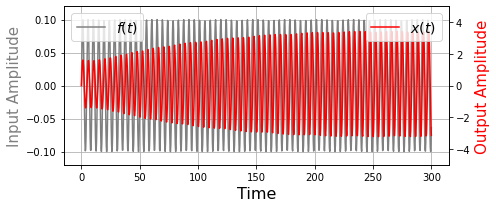

In [20]:
ts = np.linspace(0,300,1000) #時間軸を表す数列
gata_param[-1] = 1.38 #共振曲線が二重になるOmega

# ある初期値
X0a = [0, 2]
forces, xs = Solve(gata_funcs, gata_param, X0a, ts)
output_waves(ts, forces, xs, ymax1=0.12, ymax2=5)

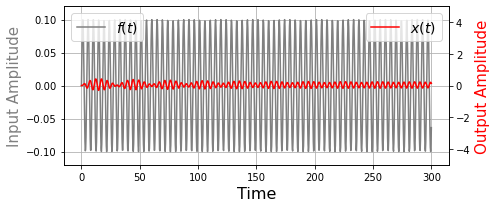

In [21]:
# 別の初期値
X0b = [0, 0]
forces, xs = Solve(gata_funcs, gata_param, X0b, ts)
output_waves(ts, forces, xs, ymax1=0.12, ymax2=5)

### ガタがある場合の位相差

- 正弦波を入力していますが，非線形系なので，出力波形は正弦波ではなくなります．
- 入力と出力の波形が異なるので，以下は，あくまで近似的な，数値計算の結果となります．
- ちなみに，数学的に理論計算する方法もありますが，やはり近似解しか出せません．

In [22]:
# 少々時間がかかります

#上昇掃引
oms_u, phis_u = measure_phase_plot(
    gata_funcs, gata_param, X0, 1, 1.6, n_om=200, Tn=150, dTn=200)
#下降掃引
oms_d, phis_d = measure_phase_plot(
    gata_funcs, gata_param, X0, 1.6, 1, n_om=200, Tn=150, dTn=200)

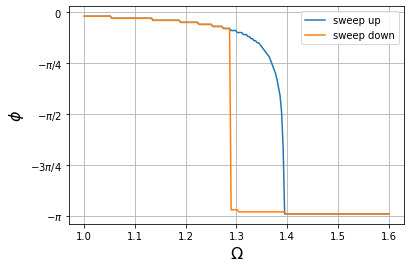

In [23]:
plt.plot(oms_u, phis_u, label='sweep up')
plt.plot(oms_d, phis_d, label='sweep down')
plt.xlabel(r'$\Omega$', fontsize=16)
plt.ylabel(r'$\phi$', fontsize=16)
plt.yticks(
    np.linspace(0,-np.pi,5),
    [r'$0$',r'$-\pi/4$',r'$-\pi/2$',r'$-3\pi/4$',r'$-\pi$']
)
plt.legend()
plt.grid()

位相差も，共振曲線と同じ場所でジャンプしています．